In [1]:
import json
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pydicom as pdc
import tensorflow as tf

sys.path.append(pathlib.Path.cwd().parent.as_posix())
from src.data.preprocess.lib.tfrecord import create_example_fn, parsed_example_fn
from src.data.preprocess.lib.utils import get_pos_from_bin_list, get_pos_from_mult_list
from src.models.lib.data_loader import preprocess_img

2023-06-10 22:34:21.720846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 22:34:21.981159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/adit/.gvm/pkgsets/go1.19.4/global/overlay/lib:/home/adit/.gvm/pkgsets/go1.19.4/global/overlay/lib:
2023-06-10 22:34:21.981188: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-10 22:34:23.183744: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load d

Patient 5 Image 2/24 (009)
RCA


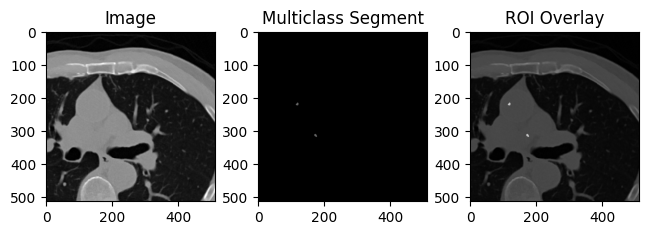

In [2]:
project_root_path = pathlib.Path.cwd().parent

patient_idx = 5
patient_img_idx = 1

clean_json_path = list(project_root_path.rglob("clean*.json"))[0]
mult_json_path = list(project_root_path.rglob("mult*.json"))[0]
bin_json_path = list(project_root_path.rglob("bin*.json"))[0]

with clean_json_path.open(mode="r") as json_file:
    clean_dict_output = json.load(json_file)

with mult_json_path.open(mode="r") as json_file:
    mult_dict_output = json.load(json_file)

with bin_json_path.open(mode="r") as json_file:
    bin_dict_output = json.load(json_file)

patient_info = clean_dict_output[str(patient_idx).zfill(3)]


patient_img_info = patient_info[patient_img_idx]

patient_img_num = patient_img_info["idx"]

print(
    f"Patient {patient_idx} Image {patient_img_idx+1}/{len(patient_info)} ({patient_img_num})"
)

patient_root_path = next(project_root_path.rglob(f"patient/{patient_idx}"))
patient_dcm_path = next(
    patient_root_path.rglob(f"*00{str(patient_img_num).lstrip('0').zfill(2)}.dcm")
)

patient_dcm = pdc.dcmread(patient_dcm_path)
patient_img_arr = patient_dcm.pixel_array
patient_img_hu = pdc.pixel_data_handlers.util.apply_modality_lut(
    patient_img_arr, patient_dcm
)

patient_roi = patient_img_info["roi"]
plot_dict = {}

for roi in patient_roi:
    vessel_loc = roi["loc"]
    vessel_pos = plot_dict.get(vessel_loc, [])
    vessel_pos.extend(roi["pos"])
    plot_dict[vessel_loc] = vessel_pos

plot_dictfig, ax = plt.subplots(1, 3)

ax[0].set_title("Image")
ax[0].imshow(patient_img_arr, cmap="gray", interpolation="none")

ax[1].set_title("Multiclass Segment")
ax[1].imshow(np.ones([512, 512]), cmap="gray")

for loc, p in plot_dict.items():
    temp = np.zeros((512, 512))
    temp[tuple(zip(*p))] = 1
    ax[1].imshow(np.transpose(temp), cmap="gray", alpha=0.4)

ax[2].set_title("ROI Overlay")
ax[2].imshow(patient_img_arr, cmap="gray", interpolation="none")
for loc, p in plot_dict.items():
    temp = np.zeros((512, 512))
    temp[tuple(zip(*p))] = 1
    ax[2].imshow(np.transpose(temp), cmap="gray", alpha=0.5)
    print(loc)
    # break

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [3]:
data = {
    "patient_num": "005",
    "idx": "009",
    "img": patient_img_hu,
    "bin_seg": np.array(get_pos_from_bin_list(bin_dict_output["005"], "009")),
    "mult_seg": np.array(get_pos_from_mult_list(mult_dict_output["005"], "009")),
}
data["segment_val"] = np.ones(data["mult_seg"].shape[0])

In [4]:
example = create_example_fn(data)

2023-06-10 22:34:28.694694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/adit/.gvm/pkgsets/go1.19.4/global/overlay/lib:/home/adit/.gvm/pkgsets/go1.19.4/global/overlay/lib:
2023-06-10 22:34:28.694861: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-10 22:34:28.694913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-VQF2EJN): /proc/driver/nvidia/version does not exist
2023-06-10 22:34:28.695769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, r

In [6]:
features = parsed_example_fn(example.SerializeToString())

In [8]:
input_dims = [512, 512, 1]

# Preprocess input image
preprocessed_img = preprocess_img(features["img"])
preprocessed_img = tf.reshape(preprocessed_img, input_dims)

# Prepare binary segmentation tensor
bin_seg_dim = (input_dims[0], input_dims[1])
bin_seg = tf.SparseTensor(
    dense_shape=bin_seg_dim,
    values=features["segment_val"],
    indices=features["bin_seg"],
)
bin_seg = tf.sparse.reorder(bin_seg)
bin_seg = tf.sparse.to_dense(bin_seg)
bin_seg = tf.reshape(bin_seg, [input_dims[0], input_dims[1], 1])

# Prepare multi-class segmentation tensor
mult_seg_dim = (input_dims[0], input_dims[1], 5 - 1)
mult_seg_indices = tf.subtract(features["mult_seg"], [[0, 0, 1]])

# Convert bin_seg to mult_seg
bin_to_mult = tf.cast(tf.where(bin_seg == 0, 1, 0), tf.float32)

# Convert mult_seg_indices to dense mult_seg
converted_indices = tf.where(
    tf.equal(mult_seg_indices, -1),
    mult_seg_indices + 1,
    mult_seg_indices,
)
dense_mult_seg = tf.SparseTensor(
    dense_shape=mult_seg_dim,
    values=features["segment_val"],
    indices=converted_indices,
)
dense_mult_seg = tf.sparse.reorder(dense_mult_seg)
dense_mult_seg = tf.sparse.to_dense(dense_mult_seg)

# Concatenate bin_to_mult and dense_mult_seg along the last dimension
mult_seg = tf.concat(
    [
        bin_to_mult,
        tf.reshape(dense_mult_seg, mult_seg_dim),
    ],
    axis=2,
)

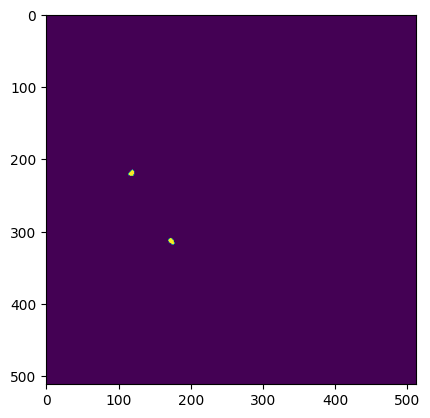

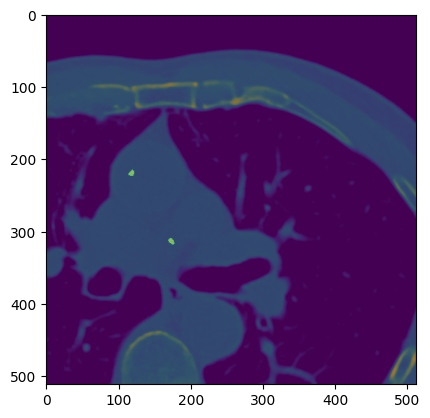

In [25]:
plt.imshow(preprocessed_img)
plt.imshow(np.transpose(bin_seg.numpy()[:,:,0]),alpha=0.5)
plt.show()

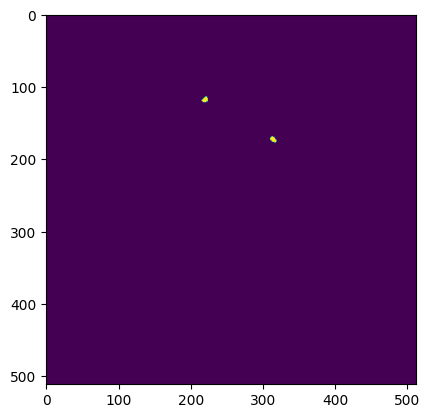

In [19]:
temp_arr = np.zeros((512, 512))
temp_arr[tuple(zip(*plot_dict["RCA"]))] = 1
plt.imshow(temp_arr)